# This file shows the process of creating an EA using ARIEL 

### How does ARIEL EC module work?

The ARIEL EC (Evolutionary Computing) module works a bit different than other EAs (Evolutionary Algorithms). While other EAs represent the population as a simple list of individuals, here they the population is made as its own class, with a population being type of `list[Individuals]`. 

Similarly, in traditional EA architecture an individual is chosen for certain operators (for example parent selection) according to some criteria, put into a separate list and then given to the operator function. ARIEL works by giving individuals what we call `tags`. An individual has `tags` that can be toggled, which qualify it for any and all operations. The tag can be whether an individual can crossover or mutate in the future, but it can also show if it can enter the learning cycle.

The tags can be changed at all times, and default values for each tag can be given to more closely represent a traditional EA structure.

Additionally, ARIEL utilizes an SQL database to handle the variables and outputs of the code. This makes the code run faster, but it adds an extra step to the process.

This file demonstrates the process of initializing an EA class and running it for a simple problem, in our case, the Sphere function.

In [ ]:
# Standard library
import random
from typing import Literal, cast

# Pretty little errors and progress bars
from rich.console import Console
from rich.traceback import install

# Third-party libraries
import numpy as np

# Local libraries
from ariel.ec.a000 import IntegerMutator
from ariel.ec.a001 import Individual
from ariel.ec.a005 import Crossover
from ariel.ec.a004 import EASettings, EAStep, EA, Population

# Library to show fitness landscape
from fitness_plot import fitness_landscape_plot


#### Define fitness function

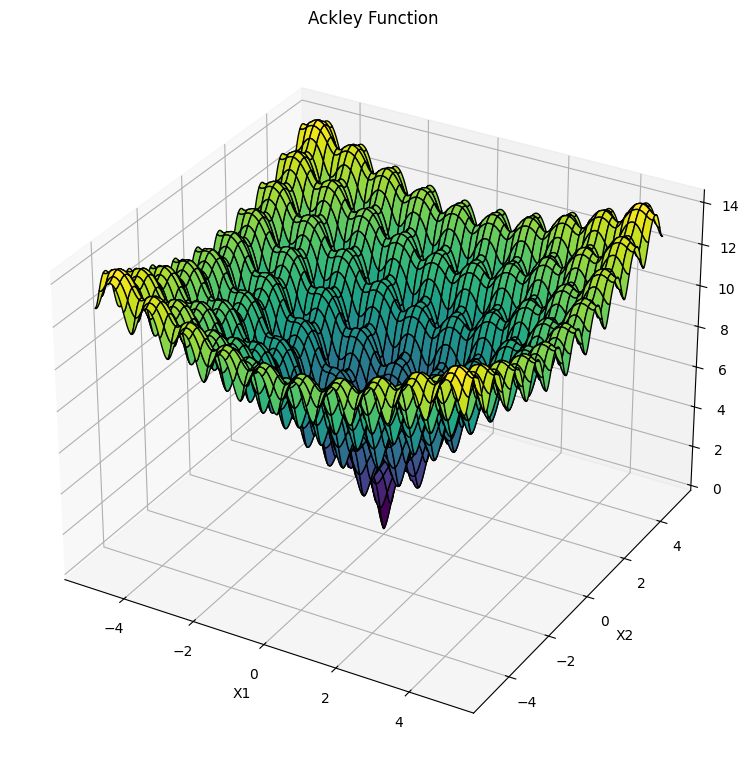

In [2]:
#### Define the fitness function
def Ackley(x):
    """source: https://www.sfu.ca/~ssurjano/ackley.html"""

    x = np.array(x)
    # Ackley function parameters
    a = 20
    b = 0.2
    c = 2 * np.pi
    dimension = len(x)

    # Individual terms
    term1 = -a * np.exp(-b * np.sqrt(sum(x**2) / dimension))
    term2 = -np.exp(sum(np.cos(c * xi) for xi in x) / dimension)
    return term1 + term2 + a + np.exp(1)

def evaluate_ind(ind: Individual) -> float:
    """Evaluate an individual by calculating its fitness using the Ackley function."""

    return Ackley(cast("list[float]", ind.genotype))

def evaluate_pop(population: Population) -> Population:
    """Evaluate a population by calculating the fitness of each individual."""
    for ind in population:
        if ind.requires_eval:
            ind.fitness = evaluate_ind(ind)
    return population

fitness_landscape_plot()


#### Initialize the global constants

In [3]:
# A seed is optional, but it helps with reproducibility
SEED = None  # e.g., 42

# The database has a few handling modes
    # "delete" will delete the existing database
    # "halt" will stop the execution if a database already exists
DB_HANDLING_MODES = Literal["delete", "halt"]

# Initialize RNG
RNG = np.random.default_rng(SEED)

# Initialize rich console and traceback handler
install()
console = Console()

### Initialize the EASettings class. 

The EASettings class acts as the handles the database and other parameters  

In [4]:
# Set config
config = EASettings()
config.is_maximisation = False
config.db_handling = "delete"


#### And just like that we have everything we need to get started. Now all we need to do define our evolutionary operators

Keep in mind that all operators in ARIEL have to work with the `Individual` and `Population` classes. You could define your own operators from scratch, but using the built in ones is easier.

In [5]:
def create_individual(num_dims) -> Individual:
    ind = Individual()
    ind.genotype = cast("list[float]", np.random.normal(loc=0, 
                                                        scale=50, 
                                                        size=num_dims).tolist())
    return ind

def parent_selection(population: Population) -> Population:
    """Tournament selection"""
    
    # Shuffle population to avoid bias
    random.shuffle(population)

    # Tournament selection
    for idx in range(0, len(population) - 1, 2):
        ind_i = population[idx]
        ind_j = population[idx + 1]

        # Compare fitness values and update tags
        if ind_i.fitness > ind_j.fitness and config.is_maximisation:
            ind_i.tags = {"ps": True}
            ind_j.tags = {"ps": False}
        else:
            ind_i.tags = {"ps": False}
            ind_j.tags = {"ps": True}
    return population
    
def crossover(population: Population) -> Population:
    """One point crossover"""

    parents = [ind for ind in population if ind.tags.get("ps", False)]
    for idx in range(0, len(parents), 2):
        parent_i = parents[idx]
        parent_j = parents[idx]
        genotype_i, genotype_j = Crossover.one_point(
            cast("list[float]", parent_i.genotype),
            cast("list[float]", parent_j.genotype),
        )

        # First child
        child_i = Individual()
        child_i.genotype = genotype_i
        child_i.tags = {"mut": True}
        child_i.requires_eval = True

        # Second child
        child_j = Individual()
        child_j.genotype = genotype_j
        child_j.tags = {"mut": True}
        child_j.requires_eval = True

        population.extend([child_i, child_j])
    return population

def mutation(population: Population) -> Population:
    for ind in population:
        if ind.tags.get("mut", False):
            genes = cast("list[int]", ind.genotype)
            mutated = IntegerMutator.float_creep(
                individual=genes,
                span=5,
                mutation_probability=0.5,
            )
            ind.genotype = mutated
    return population

def survivor_selection(population: Population) -> Population:

    # Shuffle population to avoid bias
    random.shuffle(population)
    current_pop_size = len(population)

    for idx in range(len(population)):
        ind_i = population[idx]
        ind_j = population[idx + 1]

        # Kill worse individual
        if ind_i.fitness > ind_j.fitness and config.is_maximisation:
            ind_j.alive = False
        else:
            ind_i.alive = False

        # Termination condition
        current_pop_size -= 1
        if current_pop_size <= config.target_population_size:
            break
    return population

### Define evolutionary loop

Now that all our operators are done, we can define the evolutionary loop and run the algorithm


In [6]:
def main() -> EA:
    """Entry point."""
    # Create initial population
    population_list = [create_individual(num_dims=10) for _ in range(10)]
    print(population_list)
    population_list = evaluate_pop(population_list)

    # Create EA steps
    ops = [
        EAStep("evaluation", evaluate_pop),
        EAStep("parent_selection", parent_selection),
        EAStep("crossover", crossover),
        EAStep("mutation", mutation),
        EAStep("evaluation", evaluate_pop),
        EAStep("survivor_selection", survivor_selection),
    ]

    # Initialize EA
    ea = EA(
        population_list,
        operations=ops,
        num_of_generations=100,
    )

    ea.run()

    best = ea.get_solution("best", only_alive=False)
    console.log(best)

    median = ea.get_solution("median", only_alive=False)
    console.log(median)

    worst = ea.get_solution("worst", only_alive=False)
    console.log(worst)

    return ea

In [7]:
ea = main()

[Individual(id=None, alive=True, time_of_birth=-1, time_of_death=-1, requires_eval=True, fitness_=None, requires_init=False, genotype_=[2.408246382881381, 5.79605190806094, -79.54098188412165, 15.722240082230273, 40.908873629938554, 23.655791886798323, -29.0401778456501, -44.0910910860608, 46.6994979834531, 44.51539693959488], tags_={}), Individual(id=None, alive=True, time_of_birth=-1, time_of_death=-1, requires_eval=True, fitness_=None, requires_init=False, genotype_=[38.220368939127326, 60.658833461353524, 55.66507395396577, 71.31449041051489, 90.68420709242794, -41.79576370072132, -48.79004377864702, 31.46344668265647, -48.003370589026225, 14.02324800551763], tags_={}), Individual(id=None, alive=True, time_of_birth=-1, time_of_death=-1, requires_eval=True, fitness_=None, requires_init=False, genotype_=[-32.90740512919547, 25.036141835548538, 0.36711466327349074, 53.76353799300189, -38.53125411144, 5.35745175330088, -23.019156012124697, -66.337062441846, -50.75845026113798, 48.87189

[15:04:58] Database file exists at d:\University\EC TA\ariel\docs\source\EA_intro\__data__\database.db!  a004.py:98
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Output()

─────────────────────────────────────────────── EA Finished Running ───────────────────────────────────────────────

[15:05:25] Individual(                                                                             ]8;id=907311;file://C:\Users\johng\AppData\Local\Temp\ipykernel_13864\2235138345.py\2235138345.py]8;;\:]8;id=763723;file://C:\Users\johng\AppData\Local\Temp\ipykernel_13864\2235138345.py#28\28]8;;\
               time_of_birth=53,                                                                                   
               alive=False,                                                                                        
               id=2441,                                                                                            
               requires_eval=False,                                                                                
               requires_init=False,                                                                                
               tags_={'mut': True, 'ps': False},                                                                   
               time_of_death=55,                                                                                   
               fitness_=19.943074283612287,                                                                        
               genotype_=[                                                                                         
                   -44.349598792593326,                                                                            
                   22.71370375509321,                                                                              
                   41.98038192155346,                                                                              
                   -23.57200595364493,                                                                             
                   -4.0,                                                                                           
                   9.710941958036557,                                                                              
                   -15.0,                                                                                          
                   -29.219839593502666,                                                                            
                   45.0,                                                                                           
                   -3.596580788360625                                                                              
               ]                                                                                                   
           )                                                                                                       

           Individual(                                                                             ]8;id=400151;file://C:\Users\johng\AppData\Local\Temp\ipykernel_13864\2235138345.py\2235138345.py]8;;\:]8;id=598167;file://C:\Users\johng\AppData\Local\Temp\ipykernel_13864\2235138345.py#31\31]8;;\
               time_of_birth=36,                                                                                   
               alive=False,                                                                                        
               id=1594,                                                                                            
               requires_eval=False,                                                                                
               requires_init=False,                                                                                
               tags_={'mut': True, 'ps': False},                                                                   
               time_of_death=38,                                                                                   
               fitness_=21.039838308157428,                                                                        
               genotype_=[                                                                                         
                   -22.123023231520712,                                                                            
                   -51.0,                                                                                          
                   -29.0,                                                                                          
                   19.334789764916277,                                                                             
                   -11.003167733933545,                                                                            
                   54.33341825346689,                                                                              
                   6.893693921909005,                                                                              
                   -59.29463815270952,                                                                             
                   61.643872996796034,                                                                             
                   -71.15502894628382                                                                              
               ]                                                                                                   
           )                                                                                                       

           Individual(                                                                             ]8;id=605709;file://C:\Users\johng\AppData\Local\Temp\ipykernel_13864\2235138345.py\2235138345.py]8;;\:]8;id=622651;file://C:\Users\johng\AppData\Local\Temp\ipykernel_13864\2235138345.py#34\34]8;;\
               time_of_birth=60,                                                                                   
               alive=False,                                                                                        
               id=2817,                                                                                            
               requires_eval=False,                                                                                
               requires_init=False,                                                                                
               tags_={'mut': True, 'ps': False},                                                                   
               time_of_death=61,                                                                                   
               fitness_=22.007885345384366,                                                                        
               genotype_=[                                                                                         
                   -38.43861042164279,                                                                             
                   -25.580955959432835,                                                                            
                   -11.373770419240499,                                                                            
                   50.55614494636733,                                                                              
                   1.7959731101461838,                                                                             
                   60.154819324843714,                                                                             
                   19.764137429216152,                                                                             
                   -43.37437022761751,                                                                             
                   74.18702515362334,                                                                              
                   -64.28798233024189                                                                              
               ]                                                                                                   
           )                                                                                                       

## Work in progress 

### Will update with the plot showing the mean performance and standard deviation of the algorithm